<a href="https://colab.research.google.com/github/Clarxxon/labs/blob/main/Lab3-ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Деревья решений и метод ближайших соседей в задачах классификации. Метрики оценки качества обучения.

При подготовке "тетради" использовались материалы:

Открытый курс машинного обучения. Тема 3. Классификация, деревья решений и метод ближайших соседей:
- https://habr.com/ru/company/ods/blog/322534/
    
Метрики в задачах машинного обучения

- https://habr.com/ru/company/ods/blog/328372/

Отличия LabelEncoder и OneHotEncoder в SciKit Learn

- https://habr.com/ru/post/456294/

Крайне рекомендуется ознакомиться с представленными материалами до или после ознакомления с "тетрадью".

На данном занятии будет рассмотрена задача классификации. Классификация – это отнесение объекта к одной из категорий на основании его признаков. Классификация является одной из двух задач обчения с учителем (класс задач, в которых у нас есть обучающая выборка данных). Вторая задача обучения с учителем - задача регрессии. Регрессия – прогнозирование количественного признака объекта на основании прочих его признаков.
В рамках занятия будет рассмотрена задча бинарной классификации, т.е. будет всего 2 класса: 0 и 1. Задачей будет выступать вопрос: получит ли конкретный спортсмен медаль (любой ценности) на олимпиаде? Попытаемся ответить на этот вопрос с помощью таких алгоритмов машинного обучения как дерево решений и метод ближайших соседей.

Импорт необходимых библиотек:

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Путь к данным:

In [40]:
path = 'athlete_events.csv'

Считывание данных:

In [41]:
data = pd.read_csv(path)

Заполнение пустых (nan) значений:

In [42]:
data.fillna(0, inplace = True)

Посмотрим на "голову" набора данных:

In [43]:
data.head(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,0
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,0
2,3,Gunnar Nielsen Aaby,M,24.0,0.0,0.0,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,0
3,4,Edgar Lindenau Aabye,M,34.0,0.0,0.0,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,0


Для решения задачи классификации необходимо определить целевой признак - факт получения медали. Для этого текущий признак "Medal" следует преобразовать: значения "Gold", "Silver", "Bronze" заменить на 1, а значения 0 оставить без изменения. Это преобразование осуществляет следующий код:

In [44]:
data['Medal'] = data['Medal'].apply(lambda x: 1 if x != 0 else 0)

Еще раз посмотрев на "голову" набора данных можем убедиться, что значения заменены в соответствии с указанным требованием.

In [45]:
data.head(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,0
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,0
2,3,Gunnar Nielsen Aaby,M,24.0,0.0,0.0,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,0
3,4,Edgar Lindenau Aabye,M,34.0,0.0,0.0,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,1
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,0


Для того, чтобы воспользоваться рассматриваемыми алгоритмами, также следует преобразовать строковые признаки в числовые. Это необходимо:
- деревьям решений для возможности сравнения значений между собой;
- методу ближайших соседей для возможности подсчета расстояний между анализируемыми данными;

Посмотрим какие признаки на данный момент имеют тип "object" или "string" и требуеют преобразования:

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     271116 non-null  float64
 4   Height  271116 non-null  float64
 5   Weight  271116 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   271116 non-null  int64  
dtypes: float64(3), int64(3), object(9)
memory usage: 31.0+ MB


Признак ID использоваться не будет - это уникальный идентификатор спортсмена, который в значительной степени соотносится с получением медали. В реальной задаче этот признак мог бы стать одним из ключевых. Но, т.к. это учебная задача - пока следует обойтись без него.

Признак имени также не будет использоваться в рамках решения задачи классификации (можете потом сами его добавить и посмотреть как он повлияет на точность).

Для решения задачи классификации будут использованы следующие признаки: 'Sex', 'Age', 'Height', 'Weight', 'NOC', 'Season', 'Sport', 'Event'. Признаки 'Age', 'Height', 'Weight' уже имеют числовые значения и их преобразование не требуется.
Т.к. признаки 'Sex' и 'Season' содержать всего по 2 уникальных значения - их можно преобразовать с использованием lambda:

In [47]:
data['Sex'] = data['Sex'].apply(lambda x: 1 if x == 'M' else 0)
data['Season'] = data['Season'].apply(lambda x: 1 if x == 'Summer' else 0)

Признаки 'NOC', 'Sport', 'Event' содержат гораздо большее количество уникальных значений, поэтому их преобразование вручную может потребовать много времени. Для автоматического преобразования строкового признака в числовой можно возпользоваться кодировщиком LabelEncoder из библиотеки sklearn.preprocessing. LabelEncoder закодирует каждое уникальное значение столбца целым числом и заменит все значения столбца числами.

<b>Следует сделать очень важное заменчание.</b> LabelEncoder переведет признаки 'NOC', 'Sport', 'Event' в набор чисел. Но это всего лишь категориальные данные, и между числами на самом деле нет никакой связи. Т.е. например спорт > 50 не будет нести какой-либо смысловой нагрузки. Для того, чтобы правильно закодировать категориальные признаки, следует воспользоваться OneHotEncoder или pandas.get_dummies При помощи этих инструментов для каждого категориального признака будет создан свой столбец. Но, чтобы упростить данное занятие и сосредоточиться непосредственно на алгоритмах, описанные преобразования будут рассмотрены в следующем занятии.

Преобразование с исользованием LabelEncoder:

In [48]:
data['NOC']

0         CHN
1         CHN
2         DEN
3         DEN
4         NED
         ... 
271111    POL
271112    POL
271113    POL
271114    POL
271115    POL
Name: NOC, Length: 271116, dtype: object

In [49]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data['NOC'] = le.fit_transform(data['NOC'])
data['Sport'] = le.fit_transform(data['Sport'])
data['Event'] = le.fit_transform(data['Event'])

Выделим из набора данных целевой признак:

In [50]:
target = data['Medal']
target

0         0
1         0
2         0
3         1
4         0
         ..
271111    0
271112    0
271113    0
271114    0
271115    0
Name: Medal, Length: 271116, dtype: int64

Выделим только те колонки, которые будут признаками для классификации:

In [51]:
cols = ['Sex', 'Age', 'Height', 'Weight', 'NOC', 'Season', 'Sport', 'Event']
data = data[cols]

И посмотрим на получившийся кадр данных:

In [52]:
data.head(5)

,Sex,Age,Height,Weight,NOC,Season,Sport,Event
0,1,24.0,180.0,80.0,41,1,8,159
1,1,23.0,170.0,60.0,41,1,32,397
2,1,24.0,0.0,0.0,55,1,24,348
3,1,34.0,0.0,0.0,55,1,61,709
4,0,21.0,185.0,82.0,145,0,53,622


Учитывая, что все признаки теперь числовые - можно перейти к созданию моделей. В первую очередь требуется импортировать необходимые библиотеки:

In [53]:
#Деревья решений
from sklearn.tree import DecisionTreeClassifier
#Разбивка набора данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split

Весь набор данных будет разделен на обучающую и тестовую выборки в соотношении 70:30 с использованием train_test_split:

In [76]:
X_train, X_holdout, y_train, y_holdout = train_test_split(data, target, test_size=0.2, random_state=42)

Посмотрим на размер получившихся выборок:

In [77]:
X_train.shape, X_holdout.shape, y_train.shape, y_holdout.shape

((216892, 8), (54224, 8), (216892,), (54224,))

In [78]:
y_train


97952     0
151066    0
13248     0
5803      0
249601    0
         ..
119879    0
259178    0
131932    0
146867    0
121958    0
Name: Medal, Length: 216892, dtype: int64

Создание дерева классификаии с использованием критерия качества разбиения - энтропия и максимальной глубиной дерева = 5.

In [79]:
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=17)

Обучение дерева:

In [80]:
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=17)

Проведем процедуру "предсказания" полчения медали:

In [81]:
pred = clf_tree.predict(X_holdout)
pred

array([0, 0, 0, ..., 0, 0, 0])

Теперь требуется оценить качество полученных предсказаний. В первую очередь следует попробовать accuracy_score из библиотеки sklearn.metrics.

In [82]:
from sklearn.metrics import accuracy_score

In [83]:
accuracy_score(y_holdout, pred)

0.8548059899675421

Полученный результат ~ 85% точных предсказаний. Однако, учитывая что одно дерево решений - это очень слабый алгоритм, данный показатель выглядит как минимум странно. Для понимания почему получено такое высокое значение следует обратиться к формуле расчета показателя accuracy:

![image.png](attachment:image.png)

где:
- TP - верные предсказания по классу 1;
- FP - неверные предсказания по классу 1;
- TN - верные предсказания по классу 0;
- FN - неверные предсказания по классу 0;

Общее количество значений класса 1 в наборе данных:

In [84]:
target.sum()

39783

Общее количество строк в наборе данных:

In [85]:
data.shape[0]

271116

Соотношение количества записей с классом 1 к общему количеству записей:

In [86]:
target.sum() / data.shape[0]

0.14673792767671404

Т.е. этот показатель говорит о том, что даже если отнести все предстказания к классу 0, то accuracy будет равен:

In [87]:
(0 + target.shape[0] - target.sum()) / (0 + target.shape[0] - target.sum() + 0 + target.sum())

0.853262072323286

Значение accuracy, полученное с помощью дерева решений, всего на 0.003657942678200188 больше, чем если бы все предсказания были отнесены к классу 0. Такая ситуация возникает из-за значительного дисбаланса классов (0 намного больше, чем 1). И в подобных ситуациях метрика accuracy не показательна.

Более показательными в данном случае будут метрики precision, recall и агрегированные критерии на их основе.
![image.png](attachment:image.png)

![image.png](attachment:image.png)

Как видно из формул и изображения:
- precision - это соотношение правильных предсказаний класса 1 по отношению к сумме правильных и не правльных предсказаний класса 1;
- recall - это соотношение правильных предсказаний класса 1 по отношению к сумме правильных предсказаний класса 1 и неправильных предсказаний класса 0;

Инструмент classification_report позволяет сразу оценить precision, recall и f1-score сделанных предсказаний. (Подробно про f1-score можно прочитать в материале - https://habr.com/ru/company/ods/blog/328372/)



In [88]:
from sklearn.metrics import classification_report

In [89]:
report = classification_report(y_holdout, pred)
print (report)

              precision    recall  f1-score   support

           0       0.86      1.00      0.92     46290
           1       0.58      0.03      0.06      7934

    accuracy                           0.85     54224
   macro avg       0.72      0.51      0.49     54224
weighted avg       0.82      0.85      0.79     54224



Как видно из полученной таблицы - доля верных предсказаний класса 1 по метрике recall - вего 0.02%. Попытаемся улучшить точность путем увеличения глубины дерева.

In [68]:
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=17)
clf_tree.fit(X_train, y_train)
pred = clf_tree.predict(X_holdout)

In [69]:
report = classification_report(y_holdout, clf_tree.predict(X_holdout))
print (report)

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     46290
           1       0.56      0.42      0.48      7934

    accuracy                           0.87     54224
   macro avg       0.73      0.68      0.70     54224
weighted avg       0.85      0.87      0.86     54224



Как видно, при глубине дерева = 20, recall = 0.4, что уже значительно лучше. А f1-score, который объединяет precission и recall, возрос до 0.47, что является одним из лучших значений, которое можно достичь с применением 1 дерева решений.
Можно также попробовать использовать другой критерий качества разбиения в узлах - Неопределенность Джини.

In [ ]:
clf_tree = DecisionTreeClassifier(criterion='gini', max_depth=20, random_state=17)
clf_tree.fit(X_train, y_train)
pred = clf_tree.predict(X_holdout)

In [ ]:
report = classification_report(y_holdout, clf_tree.predict(X_holdout))
print (report)

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     69460
           1       0.53      0.42      0.47     11875

    accuracy                           0.86     81335
   macro avg       0.72      0.68      0.69     81335
weighted avg       0.85      0.86      0.85     81335



При этом f1-score остался неизменным, но изменились значения precision и recall.

Для автоматического подбора параметров модели можно воспользоваться инструментом GridSearchCV. Суть того, как работает GridSearchCV: для каждой уникальной пары значений параметров max_depth и max_features будет проведена 5-кратная кросс-валидация и выберется лучшее сочетание параметров.

Параметр max_depth будет изменяться в диапазоне от 1 до 31 с шагом 5. Параметр max_features (количество используемых признаков) будет изменяться в диапазоне от 1 до 7 с шагом 1.

In [90]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import recall_score

In [ ]:
tree_params = {'max_depth': range(1,32,5),
'max_features': range(4,7)}

In [ ]:
tree_grid = GridSearchCV(clf_tree, tree_params, scoring = 'recall',
cv=5, n_jobs=-1,
verbose=True)

In [ ]:
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy', max_depth=20,
                                              random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 32, 5),
                         'max_features': range(4, 7)},
             scoring='recall', verbose=True)

In [ ]:
tree_grid.best_params_

{'max_depth': 31, 'max_features': 6}

In [ ]:
tree_grid.best_score_

0.47084651839648145

In [ ]:
recall_score(y_holdout, tree_grid.predict(X_holdout))

0.4844971010839425

В результате найдены лучшие параметры модели: глубина дерева - 31, количество признаков - 6. Оценка на кросс-валидации ~ 0.47, оценка recall на отложенной выборке ~ 0.48.

Полученно дерево решений можно визуализировать с применением export_graphviz. Предварительно необходимо переобучить дерево с малой глубиной, чтобы можно было рассмотреть все дерево.

In [ ]:
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

In [ ]:
# используем .dot формат для визуализации дерева
from sklearn.tree import export_graphviz
export_graphviz(clf_tree, feature_names=['Sex', 'Age', 'Height', 'Weight', 'NOC', 'Season', 'Sport', 'Event'],
out_file='small_tree.dot', filled=True)
# для этого понадобится библиотека pydot (pip install pydot)
!dot -Tpng 'small_tree.dot' -o 'small_tree.png'

Error: dot: can't open 'small_tree.dot': No such file or directory


![image.png](attachment:image.png)
Если у Вас не отображается дерево. Оно автоматически сохранено в формате .dot в папке с данным notebook. Данные из файла (который можно открыть текстовым редактором), следует вставить в форму на сайте https://dreampuf.github.io/GraphvizOnline/ . В правой части окна дерево автоматически построится.

Попробуем рассмотренную задачу классификации решить с применением метода ближайших соседей.

Основные параметры класса sklearn.neighbors.KNeighborsClassifier:
- weights: "uniform" (все веса равны), "distance" (вес обратно пропорционален расстоянию до тестового примера) или другая определенная пользователем функция
- algorithm (опционально): "brute", "ball_tree", "KD_tree", или "auto". В первом случае ближайшие соседи для каждого тестового примера считаются перебором обучающей выборки. Во втором и третьем — расстояние между примерами хранятся в дереве, что ускоряет нахождение ближайших соседей. В случае указания параметра "auto" подходящий способ нахождения соседей будет выбран автоматически на основе обучающей выборки.
- leaf_size (опционально): порог переключения на полный перебор в случае выбора BallTree или KDTree для нахождения соседей
- metric: "minkowski", "manhattan", "euclidean", "chebyshev" и другие

In [97]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(X_train, y_train)

pred_knn = knn.predict(X_holdout)

In [98]:
report = classification_report(y_holdout, pred_knn)
print (report)

              precision    recall  f1-score   support

           0       0.88      0.97      0.93     46290
           1       0.63      0.25      0.36      7934

    accuracy                           0.87     54224
   macro avg       0.76      0.61      0.64     54224
weighted avg       0.85      0.87      0.84     54224



Как видно из результата - при значении параметра n_neighbors=10 (количество объектов по которым ищется ближайший), значение recall = 0.24, а f-1-score = 0.34.

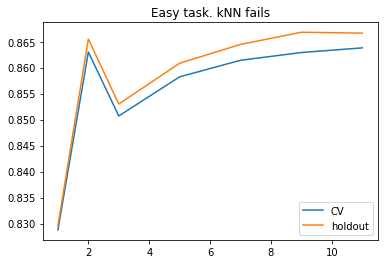

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores, holdout_scores = [], []
n_neighb = [1, 2, 3, 5, 7, 9, 11]

for k in n_neighb:

    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores.append(np.mean(cross_val_score(knn, X_train, y_train, cv=5)))
    knn.fit(X_train, y_train)
    holdout_scores.append(accuracy_score(y_holdout, knn.predict(X_holdout)))

plt.plot(n_neighb, cv_scores, label='CV')
plt.plot(n_neighb, holdout_scores, label='holdout')
plt.title('Easy task. kNN fails')
plt.legend();

### Рассмотрим еще один набор данных.

In [111]:
path1 = 'cardio.csv'

In [112]:
df = pd.read_csv(path1, index_col='id', sep=';')

In [113]:
df.shape

(70000, 12)

In [114]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


В данных присутствует 3 типа признаков:

- *Objective*: фактическая информация;
- *Examination*: результаты медицинского обследования;
- *Subjective*: информация представленная пациентом.

| Feature | Variable Type | Variable      | Value Type |
|---------|--------------|---------------|------------|
| Age | Objective Feature | age | int (days) |
| Height | Objective Feature | height | int (cm) |
| Weight | Objective Feature | weight | float (kg) |
| Gender | Objective Feature | gender | categorical code |
| Systolic blood pressure | Examination Feature | ap_hi | int |
| Diastolic blood pressure | Examination Feature | ap_lo | int |
| Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
| Smoking | Subjective Feature | smoke | binary |
| Alcohol intake | Subjective Feature | alco | binary |
| Physical activity | Subjective Feature | active | binary |
| Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

Возраст представлен в днях от рождения.

Целевой признак - cardio, которые означает, что человек в группе риска сердечных заболеваний.

Выделим целевой признак и поделим набор данных в соотношении 70:30.

In [115]:
target = df['cardio']
df.drop('cardio', axis = 1, inplace = True)

In [116]:
X_train, X_holdout, y_train, y_holdout = train_test_split(df, target, test_size=0.3,
                                                          random_state=17)

## Задание в стиле "free ride"

Используя полученные наборы данных для train и test необходимо:
- получить максимальные значения метрик accuracy и recall на тестовой выборке с использованием дерева решений;
- получить максимальные значения метрик accuracy и recall на тестовой выборке с использованием метода ближайших соседей;

Попробуйте добавить новые признаки в модель для улучшения показателя метрик, например:
- возраст в годах - поделить признак возраст на 365.25 ;create "age in years" (full age) - the remainder of dividing age in days by 365.25
- создать 3 бинарных признака, основанных на признаке cholesterol используя get_dummies или oneHotEncoder (изучить самостоятельно);
-  создать 3 бинарных признака основанных на признаке gluc;
- и т.д.

In [117]:
# создаем модель
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=17)

In [118]:
# обучаем модель
clf_tree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=17)

In [119]:
# используем .dot формат для визуализации дерева
from sklearn.tree import export_graphviz
export_graphviz(clf_tree, feature_names=df.columns,out_file='small_tree.dot', filled=True)
# для этого понадобится библиотека pydot (pip install pydot)
!dot -Tpng 'small_tree.dot' -o 'small_tree.png'

In [120]:
pred = clf_tree.predict(X_holdout)
pred


array([0, 0, 1, ..., 1, 0, 1])

In [128]:
print(f"accuracy: {accuracy_score(y_holdout, pred)}")
print(f"recall: {recall_score(y_holdout, pred)}")

accuracy: 0.7265238095238096
recall: 0.696384395813511


In [129]:
report = classification_report(y_holdout, pred)
print (report)

              precision    recall  f1-score   support

           0       0.71      0.76      0.73     10490
           1       0.74      0.70      0.72     10510

    accuracy                           0.73     21000
   macro avg       0.73      0.73      0.73     21000
weighted avg       0.73      0.73      0.73     21000



In [130]:
tree_params = {'max_depth': range(1,32,5),
'max_features': range(1,len(df.columns))}

In [131]:
tree_grid = GridSearchCV(clf_tree, tree_params, scoring = 'recall',
cv=5, n_jobs=-1,
verbose=True)

tree_grid.fit(X_train, y_train)
tree_grid.best_params_

Fitting 5 folds for each of 70 candidates, totalling 350 fits


{'max_depth': 6, 'max_features': 10}

In [132]:
pred = tree_grid.predict(X_holdout)
print(f"accuracy: {accuracy_score(y_holdout, pred)}")
print(f"recall: {recall_score(y_holdout, pred)}")

accuracy: 0.7265238095238096
recall: 0.696384395813511


KNN - модель

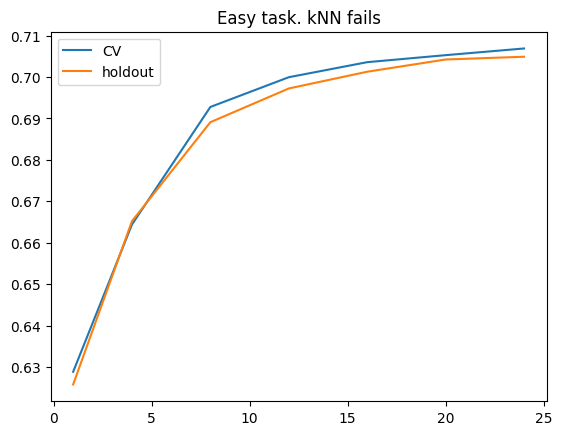

In [138]:
from sklearn.model_selection import cross_val_score

cv_scores, holdout_scores = [], []
n_neighb = [1, 4, 8, 12, 16, 20, 24]

for k in n_neighb:

    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores.append(np.mean(cross_val_score(knn, X_train, y_train, cv=5)))
    knn.fit(X_train, y_train)
    holdout_scores.append(accuracy_score(y_holdout, knn.predict(X_holdout)))

plt.plot(n_neighb, cv_scores, label='CV')
plt.plot(n_neighb, holdout_scores, label='holdout')
plt.title('Easy task. kNN fails')
plt.legend();

In [139]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train)
pred = knn.predict(X_holdout)
print(f"accuracy: {accuracy_score(y_holdout, pred)}")
print(f"recall: {recall_score(y_holdout, pred)}")

accuracy: 0.7042380952380952
recall: 0.629686013320647


**Добавляем новые признаки**

In [140]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
id,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1
1,20228,1,156,85.0,140,90,3,1,0,0,1
2,18857,1,165,64.0,130,70,3,1,0,0,0
3,17623,2,169,82.0,150,100,1,1,0,0,1
4,17474,1,156,56.0,100,60,1,1,0,0,0


In [206]:
from sklearn. preprocessing import OneHotEncoder
df = pd.read_csv(path1, index_col='id', sep=';')

df['full age'] = df['age']/365.25

encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(df[['cholesterol']]).toarray())
final_df = df.join(encoder_df)
final_df.drop('cholesterol', axis=1 , inplace=True)
final_df.rename(columns={0: "cholesterolA", 1:"cholesterolB" ,2:"cholesterolC"},inplace=True)
df = final_df
final_df.head()

,age,gender,height,weight,ap_hi,ap_lo,gluc,smoke,alco,active,cardio,full age,cholesterolA,cholesterolB,cholesterolC
id,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,0,0,1,0,50.357290,1.0,0.0,0.0
1,20228,1,156,85.0,140,90,1,0,0,1,1,55.381246,0.0,0.0,1.0
2,18857,1,165,64.0,130,70,1,0,0,0,1,51.627652,0.0,0.0,1.0
3,17623,2,169,82.0,150,100,1,0,0,1,1,48.249144,1.0,0.0,0.0
4,17474,1,156,56.0,100,60,1,0,0,0,0,47.841205,1.0,0.0,0.0


In [207]:
encoder_df = pd.DataFrame(encoder.fit_transform(df[['gluc']]).toarray())
final_df = df.join(encoder_df)
final_df.drop('gluc', axis=1 , inplace=True)
final_df.rename(columns={0: "glucA", 1:"glucB" ,2:"glucC"},inplace=True)
df = final_df
df = df.fillna(0)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,full age,cholesterolA,cholesterolB,cholesterolC,glucA,glucB,glucC
id,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,0,0,1,0,50.357290,1.0,0.0,0.0,1.0,0.0,0.0
1,20228,1,156,85.0,140,90,0,0,1,1,55.381246,0.0,0.0,1.0,1.0,0.0,0.0
2,18857,1,165,64.0,130,70,0,0,0,1,51.627652,0.0,0.0,1.0,1.0,0.0,0.0
3,17623,2,169,82.0,150,100,0,0,1,1,48.249144,1.0,0.0,0.0,1.0,0.0,0.0
4,17474,1,156,56.0,100,60,0,0,0,0,47.841205,1.0,0.0,0.0,1.0,0.0,0.0


In [208]:
df.isnull().sum()

age             0
gender          0
height          0
weight          0
ap_hi           0
ap_lo           0
smoke           0
alco            0
active          0
cardio          0
full age        0
cholesterolA    0
cholesterolB    0
cholesterolC    0
glucA           0
glucB           0
glucC           0
dtype: int64

In [209]:
target = df['cardio']
df.drop('cardio', axis = 1, inplace = True)

X_train, X_holdout, y_train, y_holdout = train_test_split(df, target, test_size=0.3,
                                                          random_state=17)

In [192]:
tree_params = {'max_depth': range(1,32,5),'max_features': range(1,len(df.columns))}
tree_grid = GridSearchCV(clf_tree, tree_params, scoring = 'recall',cv=5, n_jobs=-1,verbose=True)

tree_grid.fit(X_train, y_train)
pred = tree_grid.predict(X_holdout)
print(f"accuracy: {accuracy_score(y_holdout, pred)}")
print(f"recall: {recall_score(y_holdout, pred)}")

Fitting 5 folds for each of 105 candidates, totalling 525 fits
accuracy: 0.718
recall: 0.6941960038058992


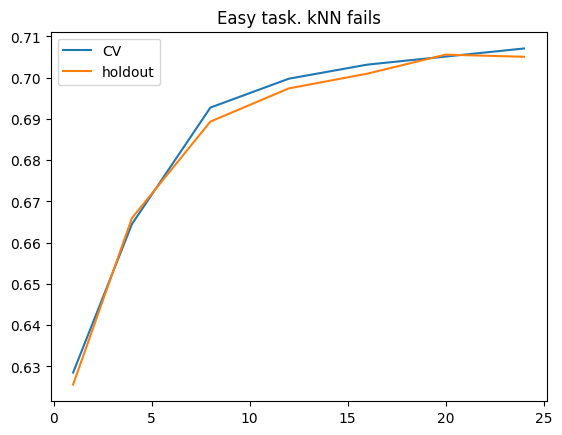

In [210]:
cv_scores, holdout_scores = [], []
n_neighb = [1, 4, 8, 12, 16, 20, 24]

for k in n_neighb:

    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores.append(np.mean(cross_val_score(knn, X_train, y_train, cv=5)))
    knn.fit(X_train, y_train)
    holdout_scores.append(accuracy_score(y_holdout, knn.predict(X_holdout)))

plt.plot(n_neighb, cv_scores, label='CV')
plt.plot(n_neighb, holdout_scores, label='holdout')
plt.title('Easy task. kNN fails')
plt.legend();

In [211]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train)
pred = knn.predict(X_holdout)
print(f"accuracy: {accuracy_score(y_holdout, pred)}")
print(f"recall: {recall_score(y_holdout, pred)}")

accuracy: 0.7055714285714285
recall: 0.6317792578496669


In [212]:
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv(path1, index_col='id', sep=';')

scaler = MinMaxScaler()
df_scaled = df
df_scaled[['height','weight','ap_hi', 'ap_lo']] = scaler.fit_transform(df_scaled[['height','weight','ap_hi', 'ap_lo']])
df_scaled

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,0.579487,0.273684,0.016079,0.013550,1,1,0,0,1,0
1,20228,1,0.517949,0.394737,0.017934,0.014453,3,1,0,0,1,1
2,18857,1,0.564103,0.284211,0.017316,0.012647,3,1,0,0,0,1
3,17623,2,0.584615,0.378947,0.018553,0.015357,1,1,0,0,1,1
4,17474,1,0.517949,0.242105,0.015461,0.011743,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99993,19240,2,0.579487,0.347368,0.016698,0.013550,1,1,1,0,1,0
99995,22601,1,0.528205,0.610526,0.017934,0.014453,2,2,0,0,1,1
99996,19066,2,0.656410,0.500000,0.020408,0.014453,3,1,0,1,0,1


In [213]:
target = df_scaled['cardio']
df_scaled.drop('cardio', axis = 1, inplace = True)

X_train, X_holdout, y_train, y_holdout = train_test_split(df_scaled, target, test_size=0.3,
                                                          random_state=17)

In [214]:
tree_params = {'max_depth': range(1,60,5),'min_samples_split': range(1,10,1)}
tree_grid = GridSearchCV(clf_tree, tree_params, scoring = 'recall',cv=5, n_jobs=-1,verbose=True)

tree_grid.fit(X_train, y_train)
pred = tree_grid.predict(X_holdout)
print(f"accuracy: {accuracy_score(y_holdout, pred)}")
print(f"recall: {recall_score(y_holdout, pred)}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
accuracy: 0.7263333333333334
recall: 0.6961941008563273


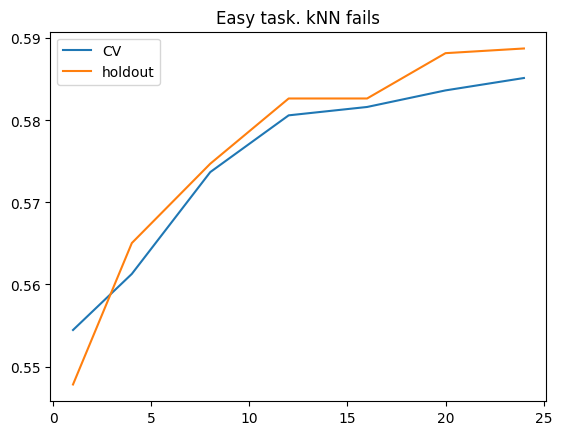

In [215]:
cv_scores, holdout_scores = [], []
n_neighb = [1, 4, 8, 12, 16, 20, 24]

for k in n_neighb:

    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores.append(np.mean(cross_val_score(knn, X_train, y_train, cv=5)))
    knn.fit(X_train, y_train)
    holdout_scores.append(accuracy_score(y_holdout, knn.predict(X_holdout)))

plt.plot(n_neighb, cv_scores, label='CV')
plt.plot(n_neighb, holdout_scores, label='holdout')
plt.title('Easy task. kNN fails')
plt.legend();

In [218]:
knn = KNeighborsClassifier(n_neighbors=26)
knn.fit(X_train, y_train)
pred = knn.predict(X_holdout)
print(f"accuracy: {accuracy_score(y_holdout, pred)}")
print(f"recall: {recall_score(y_holdout, pred)}")

accuracy: 0.5894761904761905
recall: 0.49305423406279736


Лучший результат полечен при помощи решающего дерева без добавления новых признаков и масштабирования данных
accuracy: 0.7265238095238096
recall: 0.696384395813511